In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import pickle



# the directory with all data
DATADIR = r".\adult" 
RESPONSEDIR = r".\adult\CastControls_ALP.xlsx"


# IMGWIDTH,IMGHEIGHT = (52, 70)
# IMGWIDTH,IMGHEIGHT = (130, 174)
# IMGWIDTH,IMGHEIGHT = (260, 348)
IMGWIDTH,IMGHEIGHT = (520, 696)

In [11]:
# explaination
# pd.read_excel(io=RESPONSEDIR, sheet_name=1)

In [5]:
image

'adult.zip'

In [7]:
response = pd.read_excel(io=RESPONSEDIR, sheet_name=0)
response = response.dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype(int)

import cv2
df = pd.DataFrame(columns=['GreenID','img_array'],dtype='int64')
for image in os.listdir(DATADIR):
    if 'jpg' in image:
        img_array = cv2.imread(os.path.join(DATADIR, image), cv2.IMREAD_GRAYSCALE)
        # noticed they all have shape (520, 696)
        # problly resize if out of memory
    #     img_array = cv2.resize(img_array, (IMGHEIGHT, IMGWIDTH))
        df = df.append({'GreenID':int(re.search('[0-9]+', image).group(0)), 'img_array':img_array},ignore_index=True)

train = df.merge(response, how='inner', on='GreenID')
# want to remove either missing image or missing grade record

# filter out 'ungradables', and also the the poor quality ones (add them back later, maybe)
train_filter = train[~((train.Grade >= 6.01) | (train.Grade <= 0.99) | np.isclose(train.Quality, 1))].sample(frac=1).reset_index()[['img_array', 'Grade','GreenID']]
# train_filter.img_array = train_filter['img_array'].apply(lambda x: np.array(x.flatten()))
train_filter.img_array = train_filter.img_array.apply(lambda x: x.reshape(IMGWIDTH,IMGHEIGHT,1))

In [12]:
train_filter['img_array']

0      [[166, 166, 169, 166, 165, 168, 168, 166, 172,...
1      [[163, 163, 166, 166, 168, 171, 173, 178, 183,...
2      [[156, 156, 156, 157, 158, 159, 158, 157, 155,...
3      [[192, 193, 197, 196, 201, 206, 200, 198, 203,...
4      [[204, 207, 210, 213, 213, 209, 205, 206, 208,...
                             ...                        
530    [[159, 156, 153, 152, 153, 154, 155, 157, 152,...
531    [[146, 142, 150, 149, 154, 158, 168, 184, 191,...
532    [[117, 116, 117, 118, 117, 114, 113, 114, 116,...
533    [[186, 186, 185, 183, 179, 177, 175, 173, 174,...
534    [[193, 193, 198, 195, 190, 190, 188, 191, 193,...
Name: img_array, Length: 535, dtype: object

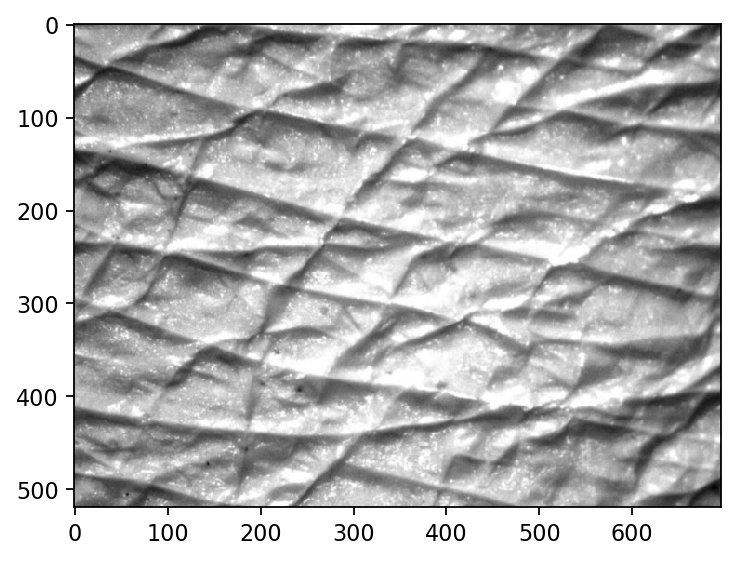

In [16]:
# see if can be reconstructed (we want to convert to 1d array and normalise within each array)
# train_filter['img_array'].apply(lambda x: x.flatten().reshape(IMGWIDTH, IMGHEIGHT))[0]
fig, ax = plt.subplots(dpi=160)
plt.imshow(train_filter['img_array'].apply(lambda x: x.flatten().reshape(IMGWIDTH, IMGHEIGHT))[0],cmap='gray')
plt.show()

In [16]:
train_filter[['img_array', 'Grade','GreenID']].to_pickle(r'.\processed_data\raw_data.pickle')

In [1]:
######################################

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import pickle
import tensorflow as tf
DATADIR = r".\adult"
RESPONSEDIR = r".\CastControls_ALP.xlsx"


# IMGWIDTH,IMGHEIGHT = (52, 70)
# IMGWIDTH,IMGHEIGHT = (130, 174)
# IMGWIDTH,IMGHEIGHT = (260, 348)
IMGWIDTH,IMGHEIGHT = (520, 696)


train_filter = pd.read_pickle(r'.\processed_data\raw_data.pickle')

In [16]:
cropped_imgs = tf.image.random_crop(value=np.stack(train_filter.head(5).img_array.values), size = (5,250,250,1)).numpy().reshape(-1,250,250)

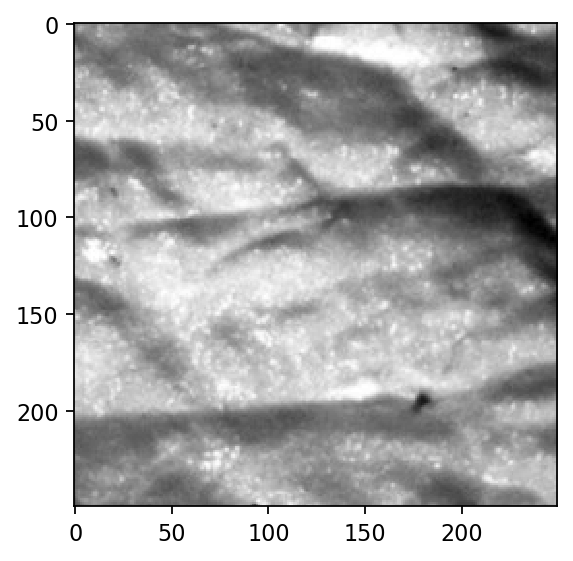

In [18]:
fig, ax = plt.subplots(dpi=160)
plt.imshow(cropped_imgs[0] ,cmap='gray')
plt.show()

In [26]:
[tf.image.random_crop(value=np.stack(train_filter.head(5).img_array.values), size = (5,250,250,1)).numpy() for i in range(3)]

[array([[[[197],
          [199],
          [203],
          ...,
          [183],
          [182],
          [182]],
 
         [[199],
          [201],
          [202],
          ...,
          [179],
          [181],
          [181]],
 
         [[205],
          [203],
          [200],
          ...,
          [176],
          [177],
          [179]],
 
         ...,
 
         [[229],
          [225],
          [220],
          ...,
          [208],
          [209],
          [206]],
 
         [[224],
          [221],
          [216],
          ...,
          [210],
          [211],
          [209]],
 
         [[218],
          [218],
          [216],
          ...,
          [214],
          [214],
          [216]]],
 
 
        [[[195],
          [197],
          [199],
          ...,
          [193],
          [191],
          [188]],
 
         [[192],
          [193],
          [197],
          ...,
          [192],
          [189],
          [187]],
 
         [[188],
    

In [23]:
# train[train.duplicated('ControlID', keep=False)].sort_values('ControlID',kind='mergesort')
# how to treat duplicated controlID? (correlation between inputs) maby be give less weight?

#### Now decide weight

In [24]:
# if differ, treat as 2 cases but half weight; if same, double the weight
# maybe give less weight to the poor qualities
# does left or right matter?
# train_filter[~train_filter.RepeatGrade.isna()]

In [25]:
X = np.array(np.stack(train_filter.img_array))

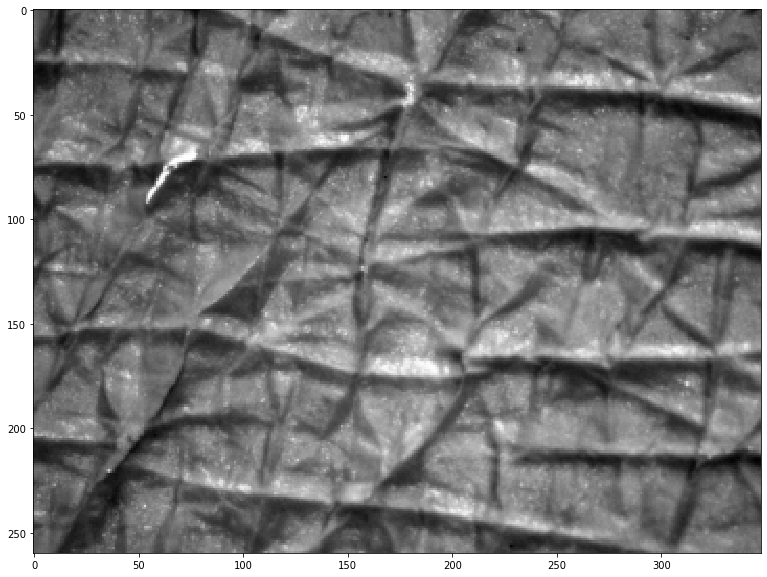

GreenID: 90 ; Rating: 2; Comments: nan


In [11]:
img = np.random.randint(np.random.randint(563))
fig, ax = plt.subplots(dpi=160)
plt.imshow(X[img],cmap='gray')
plt.show()
print('GreenID: {} ; Rating: {}; Comments: {}'.format(train_filter.GreenID[img], train_filter.Grade[img], train_filter.CastStatusComments[img]))

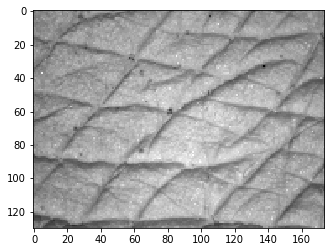

In [106]:
plt.imshow(X[2].reshape(-1,IMGWIDTH,IMGHEIGHT)[0],cmap='gray')
plt.show()

In [26]:
PROCESSEDDIR = r".\processed_data"

# do not standardise/ohe yet
X_train = X.reshape(-1,IMGWIDTH,IMGHEIGHT,1)
y_train = train_filter.Grade.values

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(handle_unknown='ignore',sparse=False, dtype=np.int)
# y_train = ohe.fit_transform(y_train.reshape(-1,1))

It is found out that fitting the entire image into the model is very inefficient; simply downscaling would also be very bad since the sample size is already extremely small. Maybe try random cropping first?